In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import math
from datetime import datetime
import statsmodels.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def tsmom(data,months):
    vol=pd.rolling_std(data.pct_change(),24)*math.sqrt(12)
    signal=data/data.shift(months)-1
    signal = signal /abs(signal)
    position=signal / vol 
    return position

def calc_pnl(position,data):
    return position*data.pct_change().shift(1)

def calc_Sharpe(pnl,N=12):
    return np.sqrt(N) * pnl.mean() / pnl.std()

def ew_portfolio_pnl(pnl):
    return pnl.divide(pnl.count(axis=1),axis=0).sum(axis=1)

In [3]:
def clean_up_columns(data):
    df=pd.DataFrame()
    for old_name in data.columns:
        new_name = old_name.split('TRc1')[0][:-1]
        df[new_name]=data[old_name]
    return df
data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='last')
price = clean_up_columns(data)
data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='mean')
vol = clean_up_columns(data)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).std()
  from IPython.kernel.zmq import kernelapp as app


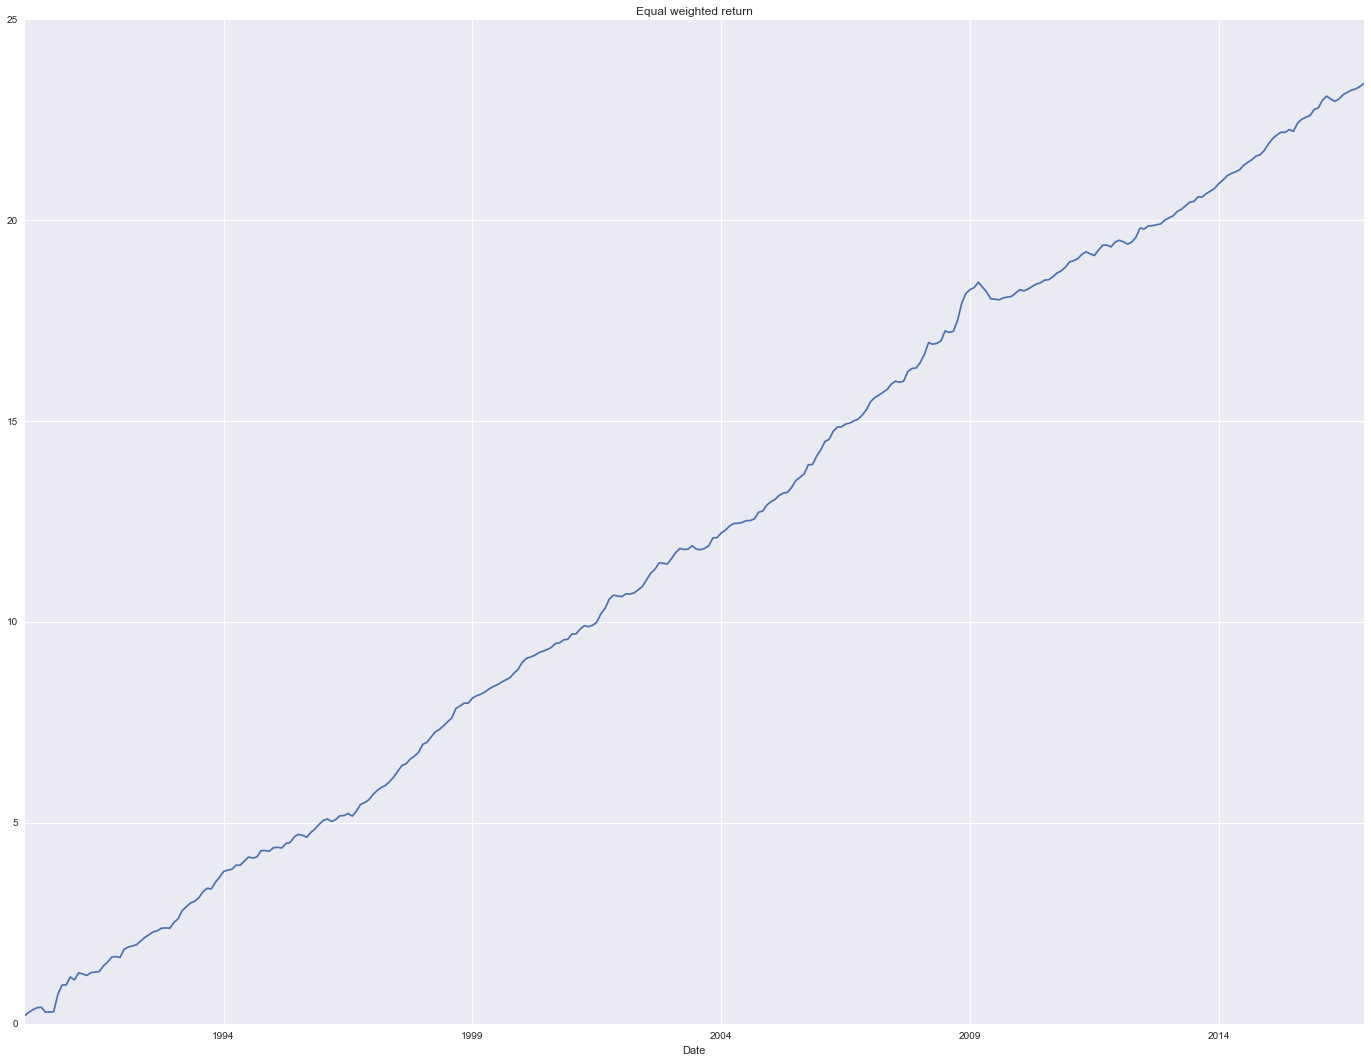

In [4]:
pos=tsmom(price,13)
pnl=calc_pnl(pos,price)
sr=calc_Sharpe(pnl)
ew_portfolio_pnl(pnl)['1990':'2016'].cumsum().plot(title='Equal weighted return')

In [5]:
x=ew_portfolio_pnl(pnl)['1990':'2016']

In [7]:
sr.sort_values().tail()

CME-S&P 500 INDEX COMP        1.307346
EUREX-LONG EURO OAT           1.315513
BMF-US DOLLAR                 1.364335
CME-3 MTH EURODOLLAR COMP.    1.524550
SFE-30 DAY INTERBANK CASH     1.717703
dtype: float64

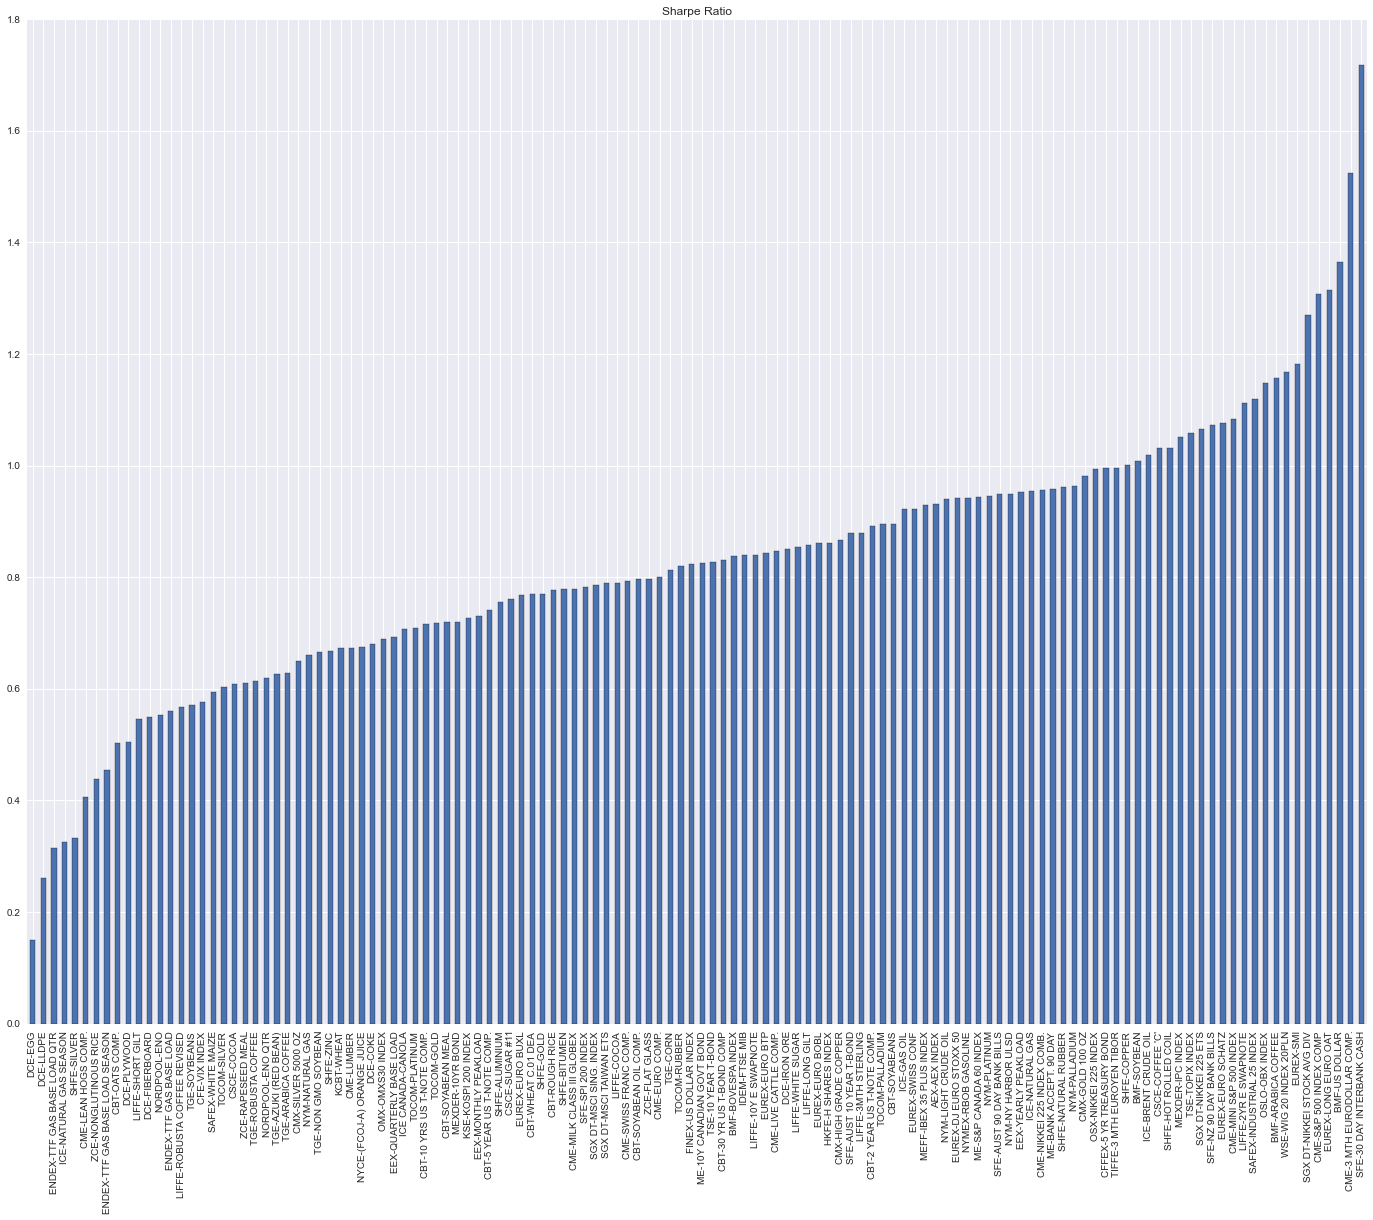

In [8]:
sr.sort_values().plot(kind='bar',title='Sharpe Ratio')

In [46]:
tstats=pd.DataFrame()
for mkt in price.columns:
    d=pd.Series()
    Y=price[mkt].resample(rule='m',how='last').pct_change().dropna()
    Y=(Y/pd.rolling_std(Y,12)).dropna()[:'2016']
    for i in range(1,36):
        X = pd.DataFrame()
        X['month']=pd.rolling_mean(Y,i).shift(1).dropna()
        X['Alpha']=1
        try:
            r= sm.OLS(Y[i:],X).fit()
        except:
            print mkt
            continue
        d['T-'+str(i)]=r.tvalues.month
    tstats[mkt]=d

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1,center=False).mean()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: pd.roll

ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
ZCE-NONGLUTINOUS RICE
DCE-PLYWOOD
DCE-PLYWOOD
DCE-PLYWOOD
DCE-PLYWOOD
DCE-PLYWOOD
DCE-PLYWOOD
DCE-PLYWOOD
DCE-FIBERBOARD
DCE-FIBERBOARD
DCE-FIBERBOARD
DCE-FIBERBOARD
DCE-FIBERBOARD
DCE-FIBERBOARD
DCE-FIBERBOARD
DCE-EGG
DCE-EGG
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL
SHFE-HOT ROLLED COIL


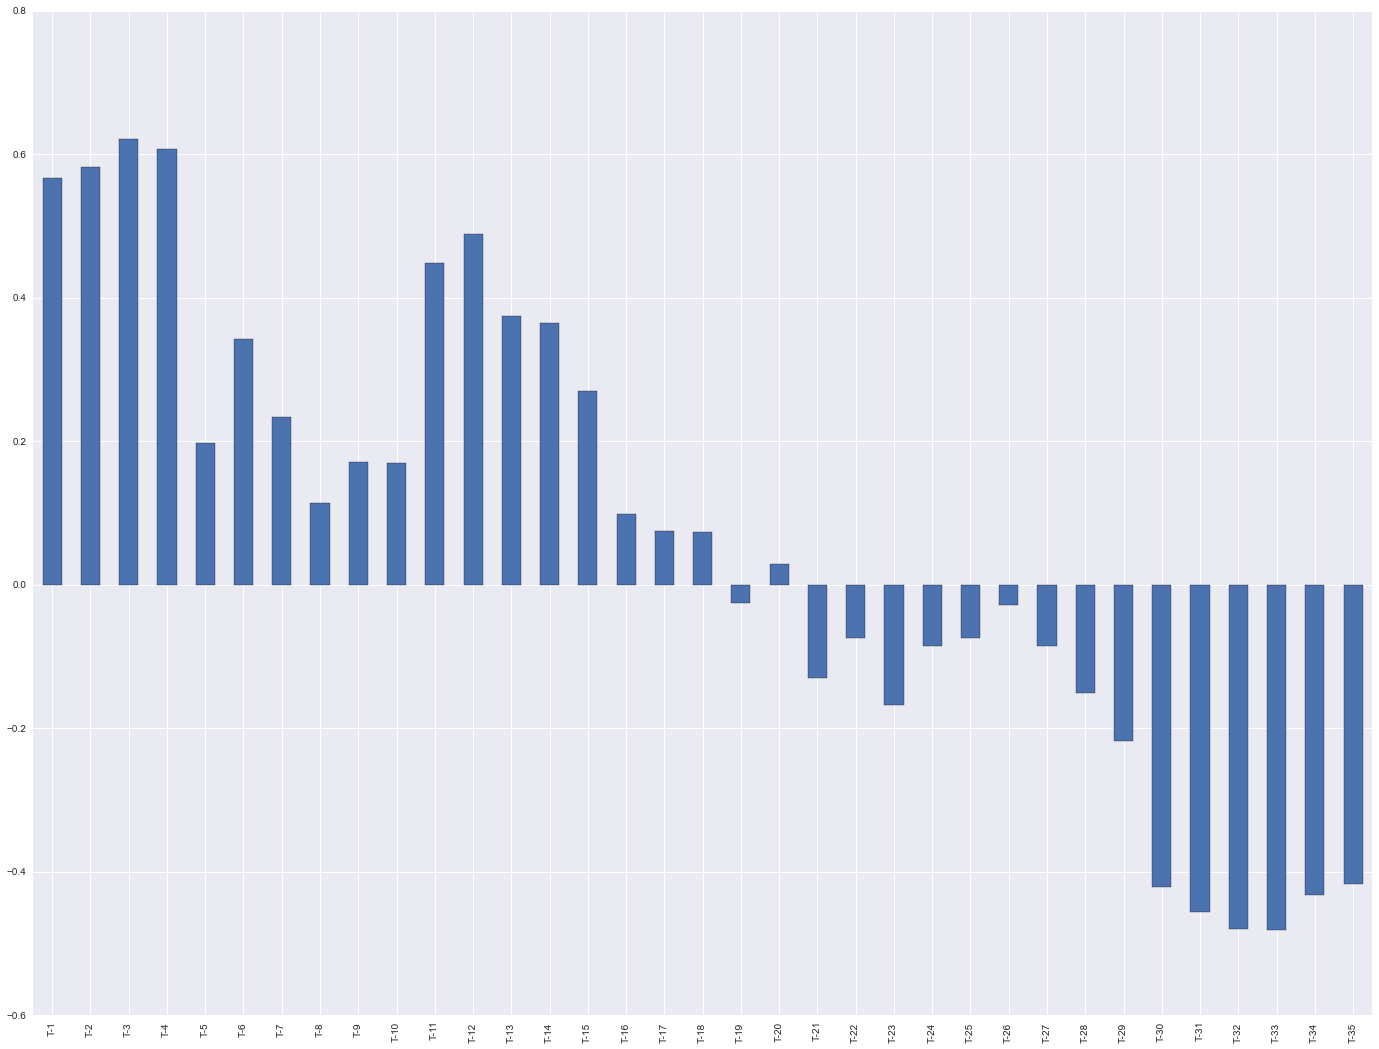

In [47]:
tstats.median(axis=1).plot(kind='bar')

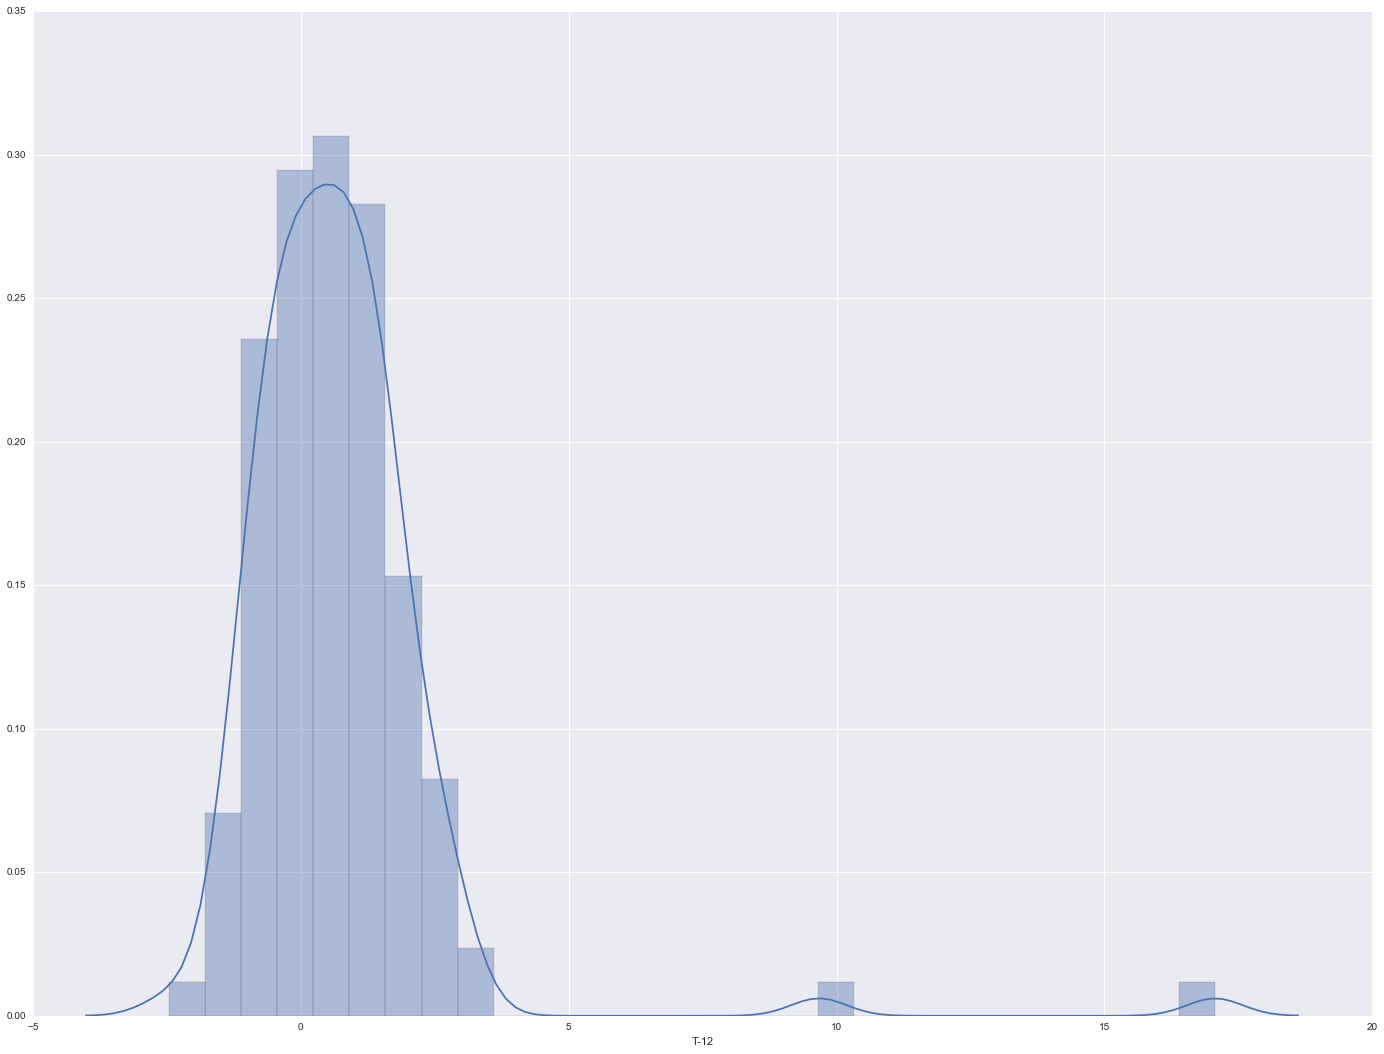

In [48]:
sns.distplot(tstats.T['T-12'].dropna())